# Import Libraries

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [3]:
train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

In [4]:
train_batch_size = 64
test_batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

# Visualization

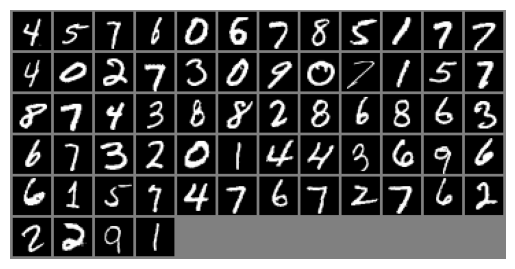

In [5]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')
    plt.axis('off')
    plt.show()

imshow(make_grid(images, nrow=12))

# Forward-Forward Network

In [6]:
class FFNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(FFNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [21]:
torch.cuda.empty_cache()

In [22]:
model = FFNetwork()
model.to(device)

FFNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

# Train and Test

In [23]:
epochs = 5

In [24]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
ff_losses = []

In [27]:
def overlay_y_on_x(x, y):
    x_ = x.clone()
    x_ = x_.view(x_.size(0), -1)
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

In [ ]:
for epoch in range(epochs):
    start_time = time.perf_counter()
    total_loss = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        x_pos = overlay_y_on_x(images, labels)
        rnd = torch.randperm(labels.size(0))
        x_neg = overlay_y_on_x(images, labels[rnd])

        outputs_pos = model(x_pos)
        outputs_neg = model(x_neg)

        loss_pos = criterion(outputs_pos, labels)
        loss_neg = criterion(outputs_neg, labels[rnd])

        loss = loss_pos + loss_neg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        ff_losses.append(total_loss)

        correct = 0
        total = 0
        test_loss = 0

        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)

                x_pos = overlay_y_on_x(images, labels)
                rnd = torch.randperm(labels.size(0))
                x_neg = overlay_y_on_x(images, labels[rnd])

                outputs_pos = model(x_pos)
                outputs_neg = model(x_neg)

                loss_pos = criterion(outputs_pos, labels)
                loss_neg = criterion(outputs_neg, labels[rnd])
                test_loss += (loss_pos + loss_neg).item()

                predictions = F.log_softmax(outputs_pos, dim=1).argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total * 100
        avg_loss = test_loss / len(test_dataloader)

        stop_time = time.perf_counter()
        
        if batch_idx % 600 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Train Loss: {loss.item():.6f}] [Test Loss: {avg_loss:.6f}] [Accuracy: {accuracy:.2f}%] [Time elapsed: {stop_time - start_time:.6}]")